In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns


In [2]:
LOW_QUANTILE = 0.25
HIGH_QUANTILE = 0.2501

# Create a Folder to Store the Results
import os

if not os.path.exists("Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE)):
    os.mkdir("Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE))
    
save_path = "Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE) + "/"

## Data

### mRNA Expression Data

In [3]:
mRNA_df = pd.read_csv('Depmap Melanoma mRNA.csv')
mRNA_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
full_mRNA_df = pd.read_csv('Depmap Pancancer mRNA.csv')
full_mRNA_df.drop(['Unnamed: 0'], axis=1, inplace=True)

### Gene Dependency Data

In [5]:
# SWAP THIS TO RUN WITH GENE EFFECT
dependency_df = pd.read_csv('Depmap Melanoma Gene Effect.csv')
dependency_df.drop(['Unnamed: 0'], axis=1, inplace=True)
print(dependency_df.shape)

(60, 17454)


### Cell Lines Data

In [6]:
cell_df = pd.read_csv('Depmap Melanoma Cells.csv')
cell_df.drop(['Unnamed: 0'], axis=1, inplace=True)
print(cell_df.shape)

(60, 5)


### Chromatin Modifying Genes

In [7]:
chromatin_genes_df = pd.read_csv("Chromatin Genes.csv")
chromatin_genes_df.head(5)

,Gene
0,ACTB
1,ACTL6A
2,ACTL6B
3,AKAP8
4,AKAP8L


### BRAF Filter

## Analysis

### Validating Assumptions / mRNA Quartiles

#### Normality Test (Shapiro-Wilk Test) for mRNA Expression and Gene Dependency

In [8]:
# Shapiro-Wilk Test for Normality for All Genes in Gene mRNA Expression Data
# Interpretation: p-value < 0.05, therefore  mRNA data is not normally distributed
results = []
for gene in mRNA_df.columns[1:]:
    results.append((gene,stats.shapiro(mRNA_df[gene])[0],stats.shapiro(mRNA_df[gene])[1]))
    
shapiro_df = pd.DataFrame(results, columns=['Gene','W-Stat','p-value'])
print(shapiro_df.shape)
print(mRNA_df.shape)
print('number of genes that are normally distributed: ', len(shapiro_df[shapiro_df['p-value'] > 0.05]))
    

c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


(19193, 3)
(60, 19194)
number of genes that are normally distributed:  7925


In [9]:
# Shapiro-Wilk Test for Normality for All Genes in Gene Dependency Data
# Interpretation: p-value < 0.05, therefore  dependency data is not normally distributed

results = []
for gene in dependency_df.columns[1:]:
    results.append((gene,stats.shapiro(dependency_df[gene])[0],stats.shapiro(dependency_df[gene])[1]))
    
shapiro_df = pd.DataFrame(results, columns=['Gene','W-Stat','p-value'])
print(shapiro_df.shape)
print(dependency_df.shape)
print('number of genes that are normally distributed: ', len(shapiro_df[shapiro_df['p-value'] > 0.05]))

(17453, 3)
(60, 17454)
number of genes that are normally distributed:  12279


#### mRNA Quartiles (Pancancer mRNA & Melanoma mRNA)

##### Chromatin mRNA Subset

In [10]:
mRNA_genes = mRNA_df.columns[1:].tolist()
chromatin_genes = chromatin_genes_df['Gene'].tolist()
intersection = list(set(chromatin_genes).intersection(mRNA_genes))

chromatin_vip_df = mRNA_df[intersection]

print(chromatin_vip_df.shape)
print(len(chromatin_genes))

(60, 497)
499


### Correlation for Chronos Scores by mRNA Groups

#### T-Tests

In [11]:
# Concatenate the vip genes dataframes
vip_genes = pd.Series(list(chromatin_vip_df.columns))
vip_genes.sort_values(inplace=True)
vip_genes.reset_index(drop=True, inplace=True)
print(vip_genes.shape)
vip_genes.head(5)

(497,)


0      ACTB
1    ACTL6A
2    ACTL6B
3     AKAP8
4    AKAP8L
dtype: object

##### Pairwise Correlations

In [12]:
 # Create a Matrix of Gene x Gene
gene_effect_matrix = np.zeros((vip_genes.shape[0], vip_genes.shape[0])) 
print(gene_effect_matrix.shape)

# Iterate through the genes
# For each gene
# Iterate through the other expression cell lines and then grab the gene dependency values
# perform correlations between the genes
for gene in vip_genes:
    
    for gene2 in vip_genes:
        
        
        # Correlation
        corr = stats.pearsonr(mRNA_df[gene], dependency_df[gene2])
        
        # Add the t-statistic to the gene effect matrix
        gene_effect_matrix[vip_genes[vip_genes == gene].index[0], vip_genes[vip_genes == gene2].index[0]] = corr[0]
        
# Save
np.savetxt(save_path + 'mRNA vs. Gene Dependency Matrix.csv', gene_effect_matrix, delimiter=",")

(497, 497)


In [13]:
# Convert to PD
gene_effect_matrix_df = pd.DataFrame(gene_effect_matrix, columns=vip_genes, index=vip_genes)

# Remove NaN rows
gene_effect_matrix_plot = gene_effect_matrix[~np.isnan(gene_effect_matrix).any(axis=1)]

In [15]:
POS_CORR = 0.5
NEG_CORR = -0.5
# Rows where the p-value is less than 0.05
significant_rows_df = gene_effect_matrix_df[(gene_effect_matrix_df < NEG_CORR) | (gene_effect_matrix_df > POS_CORR)]
# Fill NAN with 1
significant_rows_df = significant_rows_df.dropna(axis=0, how='all').dropna(axis=1, how='all')
significant_rows_df.fillna(0, inplace=True)
significant_rows_df.head(5)



,APP,BPTF,CBX5,CBX6,CENPA,CTCF,DDX11,DNMT3A,DYDC2,GTF3C4,...,KMT2A,LEF1,LIF,MBD2,PCGF6,PRDM6,RBBP7,SETD4,SETD5,SMARCAL1
APLNR,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.507139,0.0,0.0,...,0.0,0.0,-0.530043,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
CBX6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.511048,0.000000,0.0,0.0,0.0
DPPA2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.558374,0.0,0.0,0.0
GFI1,0.0,0.0,0.0,0.0,0.0,0.0,-0.548910,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
HDAC4,0.0,0.0,0.0,0.0,0.0,0.0,0.512073,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


Text(0.5, 1.0, 'mRNA vs. Gene Dependency Heatmap (Positive or Negative Correlates)')

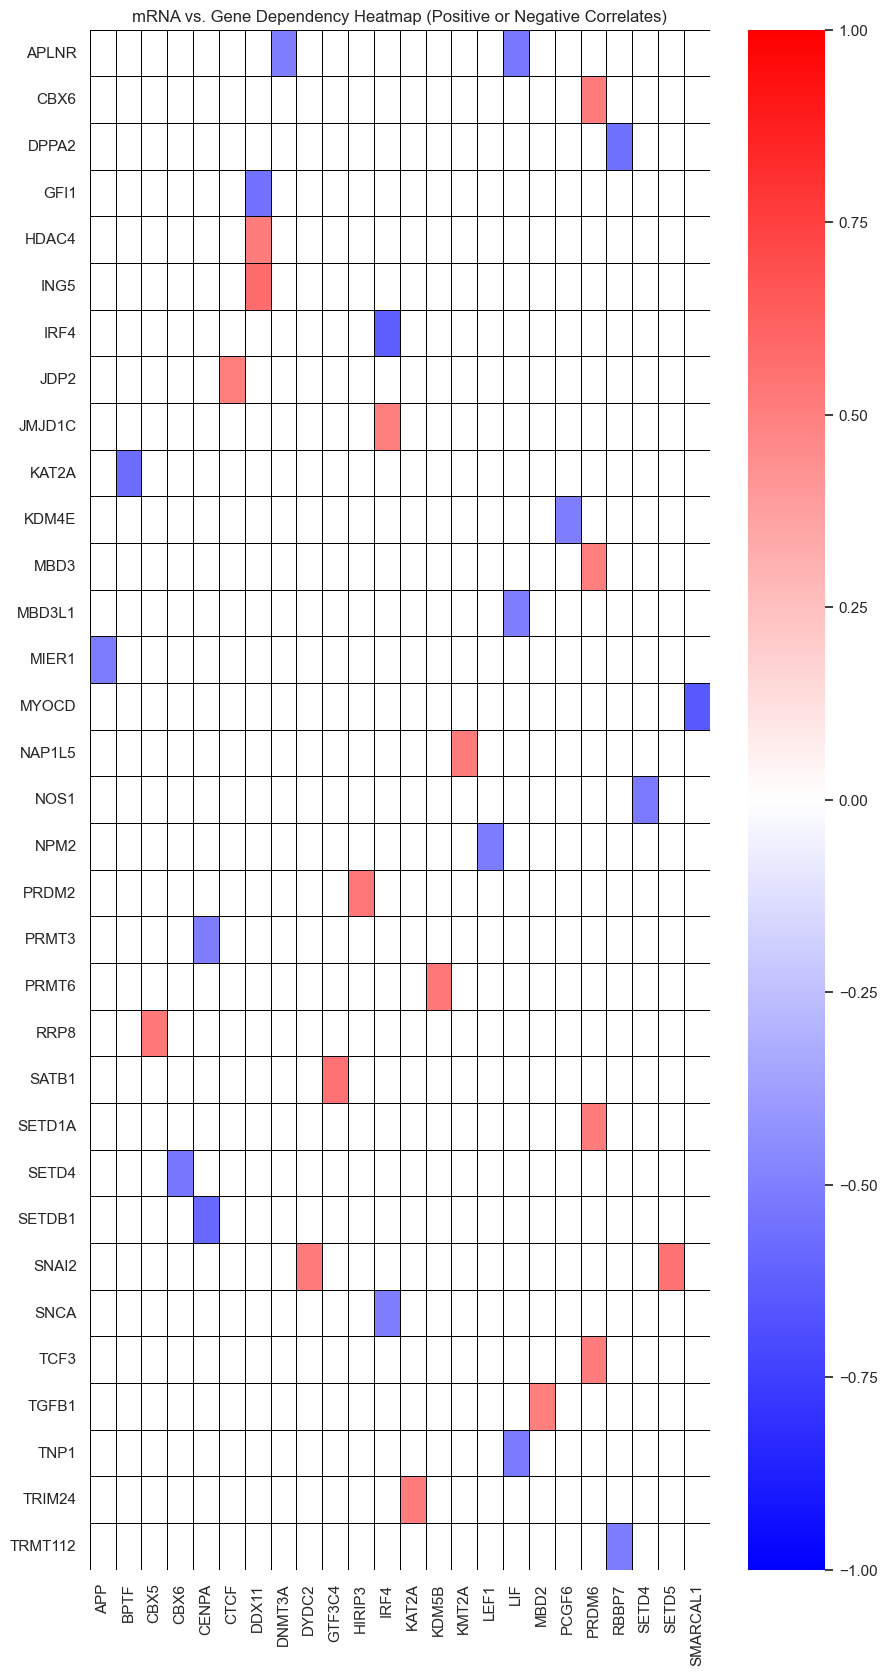

In [16]:
# Rows that were < .05
sns.set(font_scale=1)
plt.figure(figsize=(10,20))
sns.heatmap(significant_rows_df, vmin=-1, vmax=1, cmap='bwr', xticklabels=True, yticklabels=True, linewidths=0.5, linecolor='black')
plt.title('mRNA vs. Gene Dependency Heatmap (Positive or Negative Correlates)')


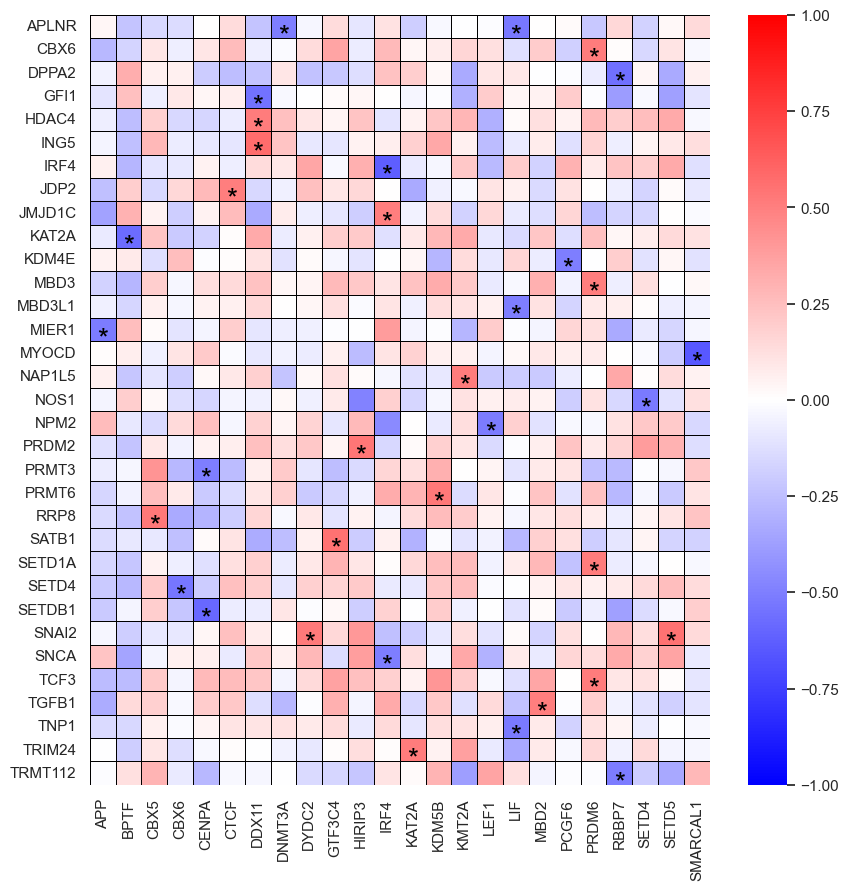

In [17]:
# Index Into Original Gene Effect Matrix with Significant Row Index and Columns
significant_gene_effect_matrix = gene_effect_matrix_df.loc[significant_rows_df.index, significant_rows_df.columns]
plt.figure(figsize=(10,10))

sns.heatmap(significant_gene_effect_matrix, vmin=-1, vmax=1, cmap='bwr', xticklabels=True, yticklabels=True, linewidths=0.5, linecolor='black')

# Add Stars to Significant Correlations < -.5 and > .5 
significant_gene_effect_matrix_stars = significant_gene_effect_matrix.copy()
significant_gene_effect_matrix_stars[significant_gene_effect_matrix_stars < NEG_CORR] = -1
significant_gene_effect_matrix_stars[significant_gene_effect_matrix_stars > POS_CORR] = 1

significant_gene_effect_matrix_stars = significant_gene_effect_matrix_stars.astype(int).astype(str)
significant_gene_effect_matrix_stars[significant_gene_effect_matrix_stars == '-1'] = '*'
significant_gene_effect_matrix_stars[significant_gene_effect_matrix_stars == '1'] = '*'

for i, c in enumerate(significant_gene_effect_matrix_stars.columns):
    for j, v in enumerate(significant_gene_effect_matrix_stars[c]):
        if v == '*':
            plt.text(i + .5, j + 1.5, v, color='black', ha = 'center', va = 'bottom', fontsize=20)


Text(0, 0.5, 'Gene DependencyMYOCD')

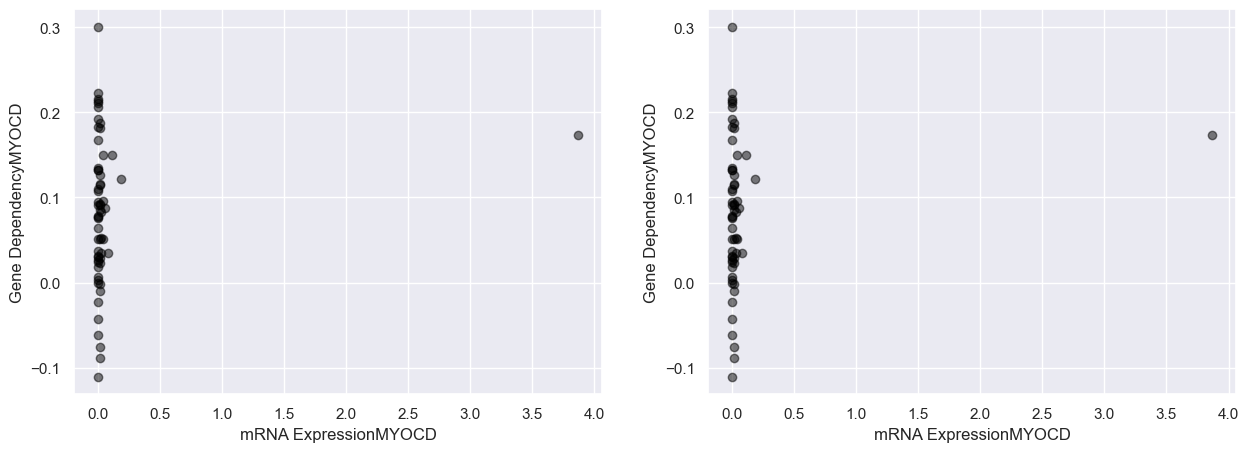

In [28]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
gene1='MYOCD'
gene2='MYOCD'
# Plot the mRNA vs. Gene Dependency 
ax[0].scatter(mRNA_df[gene1], dependency_df[gene1], color='black', alpha=0.5)
ax[0].set_xlabel('mRNA Expression' + gene1)
ax[0].set_ylabel('Gene Dependency' + gene1)

# Plot the mRNA vs. Gene Dependency
ax[1].scatter(mRNA_df[gene2], dependency_df[gene1], color='black', alpha=0.5)
ax[1].set_xlabel('mRNA Expression' + gene2)
ax[1].set_ylabel('Gene Dependency' + gene1)

In [19]:
# Manual Validation
gene = 'WDR82'
gene2 = 'MLLT1'
low_expression = gene_groups[gene_groups[gene] == 'low'].index
high_expression = gene_groups[gene_groups[gene] == 'high'].index


low_expression_dependency = dependency_df.loc[low_expression, gene2]
high_expression_dependency = dependency_df.loc[high_expression, gene2]


# T-Test of Gene Dependency in Low and High Expression Cells
ttest = stats.ttest_ind(low_expression_dependency, high_expression_dependency,  alternative = 'two-sided')

# Add the t-statistic to the gene effect matrix
significant_rows_df[vip_genes[vip_genes == gene].index[0], vip_genes[vip_genes == gene2].index[0]] = ttest[0]

fig,ax = plt.subplots(1,2,figsize=(50,15))

ax[0].hist(low_expression_dependency, bins=20, color='blue', alpha=0.5, label='Low Dependency')
ax[0].hist(high_expression_dependency, bins=20, color='red', alpha=0.5, label='High Dependency')
ax[0].legend(loc='upper left')
ax[0].set_ylabel('Frequency')
ax[0].set_title(gene2 + ' Dependency in ' + gene + ' Low and High Expression Cells')

# mRNA
ax[1].hist(mRNA_df.loc[low_expression, gene], bins=20, color='blue', alpha=0.5, label='Low Expression')
ax[1].hist(mRNA_df.loc[high_expression, gene], bins=20, color='red', alpha=0.5, label='High Expression')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('Frequency')
ax[1].set_title(gene + ' mRNA in Low and High Expression Cells')


print(low_expression.shape)
print(high_expression.shape)
print(low_expression_dependency.shape)
print(high_expression_dependency.shape)
    

NameError: name 'gene_groups' is not defined